먼저 이 ipynb 코드는 colab gpu version 상에서 작성했기 때문에, 

**Local 환경에서는 아래 몇 가지 내용을 준수해야 합니다. 그렇지 않으면 오류가 날 지 몰라요.**

- Pytorch 등의 주요 라이브러리 version을 맞춰주기
- import한 library를 Local에 직접 설치해주기 
  - 예) Error: no module name 'transformers' -> pip install transformers 


이 ipynb 코드는 Huggingface/transformers 라이브러리를 통해 제공되는 GPT-2를 활용하는 방법과 여러가지 태스크 활용 튜토리얼을 제공하기 위하여, [작성자: purang2](https://github.com/purang2)가 작성한 것입니다. 

물론 오픈소스이긴 하나 만에 하나 어떤 문제가 발생할 경우 모든 저작권은 작성자에게 있습니다. 


## GPT-2 오픈하기


GPT-3는 너무 크다. 그러한 이유에서 **GPT-2**가 아직도 많이 사용된다. 

현재 가장 많이 사용되는 모델은 

BERT (지난 달: 1850만 Downloads)이며, 

두번째는 GPT-2 (지난 달 다운로드: 1210만) 이다. 
(이용 순위 보는 법: https://huggingface.co/models)



**BERT**는 자연어 이해(Natural language understanding) 즉 문장의 카테고리 분류, 긍정 부정, 추론 등에 특화된 반면 **인코더**를 타겟으로 만들어진 것이므로 자연어 생성 연구에는 거의 적용되지 못한다. 

 **GPT-2**는 **디코더**를 타겟으로 연구된 GPT Series 중에서 적절한 성능과 GPT-3에 비해 크지 않고 BERT와 유사한 정도의 쓸만한 크기를 제공하므로 다양한 ***자연어 생성(Natural Language Generation, NLG)*** 태스크에 매우 많이 쓰이고 있다. 
 
**인코더-디코더 동시 모델**의 2대장인 **BART, T5**에게 ***텍스트 인풋-텍스트 아웃풋을 동시에 가지는 기계 번역, 문서 요약 등***의 태스크는 양보하였으나, 

GPT-2는 단순 자연어 생성 ( 첫 단어를 주고 다음 단어를 계속 추론하는 태스크)에 현재까지도 매우 독보적인 모델이므로 아직까지도 자연어 디코더의 1픽으로 많이 쓰인다. 주로 **이미지 캡셔닝의 디코더(Image captioning), 장르 별 스토리 생성(Story generator), 가사 생성, 시 생성 (Verse and Poetry generator)**의 태스크에 적용된다. 요즘 hot한 **챗봇**에도 적용되며 자세한 과정은 작성자가 잘 모르지만 대화의 흐름을 이해하여 적절한 단어 순서를 가진 말을 뱉어내므로, 

혹자들은 GPT 등의 언어 모델에 자아가 있다고 의심하기도 한다. 


---

GPT에 더욱 흥미가 생기기 시작한다면, 더욱 자세한 사항은 아래를 확인하자. 

모델 카드 주소 (개발자가 모델의 상세 정보를 제공하는 Readme): https://huggingface.co/gpt2 


---

인트로는 여기까지 하고, 이제부터 코드를 통해 만나보도록 하자. 





###우선은 GPT-2를 활용한 단순 자연어 생성 (작문 AI)가 가능한지 만나보자! 



아래 코드는 gpt-2, bert 등의 언어 모델을 손쉽게 제공하는 Hugging Face(https://huggingface.co/models)의 transformers 라이브러리를 설치한다. 앞에 붙는 느낌표는 코랩에서 cmd처럼 커맨드를 할 수 있는 매직 명령어이다. 리눅스의 cd, mkdir 등의 명령어와 더불어 pip 등을 colab에서 사용 할 수 있다. 

colab이 아닌 jupyter, visual code 등의 환경에서는 anaconda prompt를 통해 설치를 진행하고 아래 코드를 뛰어 넘으면 된다.

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 6.6 MB 65.5 MB/s 
     |████████████████████████████████| 596 kB 82.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


GPT-2의 모델 카드에 따라 아래 방식으로 GPT-2를 로드하고 동작시킬 수 있다. PyTorch를 기본으로 하며 아래 코드는 PyTorch 코드이다. Tensorflow 코드는 모델 카드 링크에 들어가서 참고한다.

이 **GPT-2는 40GB의 WebText (영어)로 프리트레인이 되어있는 모델이다.**

자연어 기반 프리트레인 모델 특성 상 모델에는 반드시 토크나이저가 따라온다. 토크나이저의 VOCAB 속 단어 토큰들이 훈련 되어 잘 표현된 벡터로 모델이 이해하기 때문이다. 토크나이저에 대한 이해가 필요하며 위키독스 등을 참조하도록 하자. 

In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

import numpy as np
import torch

#gpt_model = 'gpt2'
#gpt_model = 'gpt2-large' #Model size: 3.02 GB
gpt_model = 'gpt2-xl' #Model size: 5.99 GB


tokenizer = GPT2Tokenizer.from_pretrained(gpt_model)
model = GPT2LMHeadModel.from_pretrained(gpt_model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

prefix = """In 1991, the remains of Russian Tsar Nicholas II and his family
(except for Alexei and Maria) are discovered.
The voice of Nicholas's young son, Tsarevich Alexei Nikolaevich, narrates the
remainder of the story. 1883 Western Siberia,
a young Grigori Rasputin is asked by his father and a group of men to perform magic.
Rasputin has a vision and denounces one of the men as a horse thief. Although his
father initially slaps him for making such an accusation, Rasputin watches as the
man is chased outside and beaten. Twenty years later, Rasputin sees a vision of
the Virgin Mary, prompting him to become a priest. Rasputin quickly becomes famous,
with people, even a bishop, begging for his blessing. <eod> </s> <eos>"""

prefix = """
Abstract
Recent work has demonstrated substantial gains on many NLP tasks and benchmarks by pre-training 
on a large corpus of text followed by fine-tuning on a specific task. While typically task-agnostic in architecture, 
this method still requires task-specific fine-tuning datasets of thousands or tens of thousands of examples. 
By contrast, humans can generally perform a new language task from only a few examples or from simple instructions – 
something which current NLP systems still largely struggle to do.



"""

prompt_text = "Here we show that "
#prompt_text = input("Model prompt >>> ")

encoded_prompt = tokenizer.encode(prefix + prompt_text, add_special_tokens=False, return_tensors="pt").to(device)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

위의 코드의 model은 큰 데이터(물론 영어)로 프리트레이닝 되어있는 모델을 불러온 것이다. 

이 정도 수준에서도 일반적인 영어는 이해할 수준이 되지만 특정 태스크에 적용하는 데에는 무리가 있다고 일반적으로 본다. 

이를 위해 대부분의 연구에서는 자신 태스크에 맞는 데이터셋을 추가로 학습시키며 이 과정을 그냥 트레이닝이라고 부르는 것 보다 **파인 튜닝(Fine-tuning)**이라는 용어로 주로 부른다. 


⭐

개인 수준에서 현대적인 자연어 처리를 가장 잘 다룰 수 있는 방법은 Huggingface로 pre-train된 모델을 from transformers import Model로 불러오고 이를 자신의 데이터셋으로 파인튜닝(=트레인)시키는 과정으로 쉽게 볼 수 있다.




In [8]:
prompt = """
Recent work has demonstrated substantial gains on many NLP tasks and benchmarks by pre-training on a large corpus of text followed by fine-tuning on a specific task. 
While typically task-agnostic in architecture, this method still requires task-specific fine-tuning datasets of thousands or tens of thousands of examples. 
By contrast, humans can generally perform a new language task from only a few examples or from simple instructions – something which current NLP systems still largely struggle to do. 
Here we show that scaling up language models greatly improves task-agnostic, few-shot performance, sometimes even reaching competitiveness with prior state-of-the-art fine- tuning approaches. 
Specifically, we train GPT-3, an autoregressive language model with 175 billion parameters, 10x more than any previous non-sparse language model, and test its performance in the few-shot setting. 
For all tasks, GPT-3 is applied without any gradient updates or fine-tuning, with tasks and few-shot demonstrations specified purely via text interaction with the model. 
GPT-3 achieves strong performance on many NLP datasets, including translation, question-answering, and cloze tasks, as well as several tasks that require on-the-fly reasoning or domain adaptation, 
such as unscrambling words, using a novel word in a sentence, or performing 3-digit arithmetic. At the same time, we also identify some datasets where GPT-3’s few-shot learning still struggles, 
as well as some datasets where GPT-3 faces methodological issues related to training on large web corpora. 
"""



prompt_text = "Finally, we find that"
#prompt_text = input("Model prompt >>> ")

encoded_prompt = tokenizer.encode(prefix + prompt_text, add_special_tokens=False, return_tensors="pt").to(device)
# the answer is  "that GPT-3 can generate samples of news articles which human evaluators have difficulty distinguishing from articles written by humans. We discuss broader societal impacts of this finding and of GPT-3 in general."


In [11]:
if encoded_prompt.size()[-1] == 0:
    input_ids = None
else:
    input_ids = encoded_prompt

#Parameter 
#조절해서 쓰세용
length = 60
temperature = 1.0 #float -> help="temperature of 1.0 has no effect, lower tend toward greedy sampling"
k = 5 # int -> You can study about Top K sampling for Language Generation -> https://velog.io/@nawnoes/Top-p-%EC%83%98%ED%94%8C%EB%A7%81-aka.-Nucleus-Sampling
p = 0.9 # float -> " also Top P Sampling
repetition_penalty = 1.0 # float -> help="primarily useful for CTRL model; in that case, use 1.2" 
num_return_sequences = 5 # int -> help="The number of samples to generate."
stop_token = None # str -> help="Token at which text generation is stopped"



output_sequences = model.generate(
    input_ids=input_ids,
    max_length=length + len(encoded_prompt[0]),
    temperature=temperature,
    top_k=k,
    top_p=p,
    repetition_penalty=repetition_penalty,
    do_sample=True,
    num_return_sequences=num_return_sequences,
)



# Remove the batch dimension when returning multiple sequences
if len(output_sequences.shape) > 2:
    output_sequences.squeeze_()


generated_sequences = []

for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
    print(f"=== GENERATED SEQUENCE {generated_sequence_idx + 1} ===")
    generated_sequence = generated_sequence.tolist()

    # Decode text
    text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)

    # Remove all text after the stop token
    text = text[: text.find(stop_token) if stop_token else None]

    # Add the prompt at the beginning of the sequence. Remove the excess text that was used for pre-processing
    total_sequence = (
        prompt_text + text[len(tokenizer.decode(encoded_prompt[0], clean_up_tokenization_spaces=True)) :]
    )

    generated_sequences.append(total_sequence)
    print(total_sequence)

your_output = generated_sequences

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


=== GENERATED SEQUENCE 1 ===
Finally, we find that the best-performing NLP systems on the tasks we test (e.g. the ICA task) are often highly tuned for the tasks they are tested for and not the task they are trying to learn. This suggests that a key to improving performance is not necessarily the size of the corpus of
=== GENERATED SEQUENCE 2 ===
Finally, we find that the use of an NLP system for language processing can be highly effective in the presence of large task-specific task-specific datasets. This can be especially important in the case of natural language tasks such as translation, where a small number of training examples can be sufficient to perform a translation task.<|endoftext|>
=== GENERATED SEQUENCE 3 ===
Finally, we find that a new NLP system can be constructed by training a model on a large corpus and then fine-tuning on a specific task. The resulting system is able to learn the structure of natural language sentences and their meaning, and is able to produce natural 

In [12]:
print(your_output)

['Finally, we find that the best-performing NLP systems on the tasks we test (e.g. the ICA task) are often highly tuned for the tasks they are tested for and not the task they are trying to learn. This suggests that a key to improving performance is not necessarily the size of the corpus of', 'Finally, we find that the use of an NLP system for language processing can be highly effective in the presence of large task-specific task-specific datasets. This can be especially important in the case of natural language tasks such as translation, where a small number of training examples can be sufficient to perform a translation task.<|endoftext|>', 'Finally, we find that a new NLP system can be constructed by training a model on a large corpus and then fine-tuning on a specific task. The resulting system is able to learn the structure of natural language sentences and their meaning, and is able to produce natural language sentences with a high degree of generality.', "Finally, we find that t

### 결론

뭔가 이상하긴 한데 그래도 훈련 안 시킨 것 치고는 요상하게 잘 나오죠? 

이정도로 해보는 것으로 감을 잡을 수 있을겁니다. 다음에는 파인튜닝(트레이닝), GPT-2 다른 태스크 적용, 한국어 GPT(KoGPT) 사용 등도 업로드할 예정입니다. 과정은 크게 다르지 않으며, 자연어처리는 트레이닝 과정에서 데이터가 GB 단위인 경우가 많으므로 GPU를 사용했을 때도 많은 시간이 걸리긴 할겁니다.

## ViT-GPT2-Image Captioning 

1.   아래 모델은 vision transformer encoder와 gpt2 decoder를 묶어 둔 파이토치 인코더-디코더 모델 구조입니다, 이를 통해 Image Captioning을 실현할 수 있습니다.
2.   이 모델은 coco dataset으로 프리트레인 되어있습니다. 따라서 이 예제의 출력은 트레인을 통해 추후 개선할 수 있습니다.  



In [13]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning") 
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")  #이미지 전처리 = 이미지의 토크나이저, transformers 제공 
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading:   0%|          | 0.00/4.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/937M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/241 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/120 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out

In [38]:
from PIL import Image

max_length = 32
num_beams = 4

gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")
    i_image.show()
    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

predict_step(['5d43.jpg','rrrr.PNG','RGRG.PNG'])



['men standing next to each other in front of a building',
 'a man in a suit talking on a cell phone',
 'a woman and a man standing next to each other']

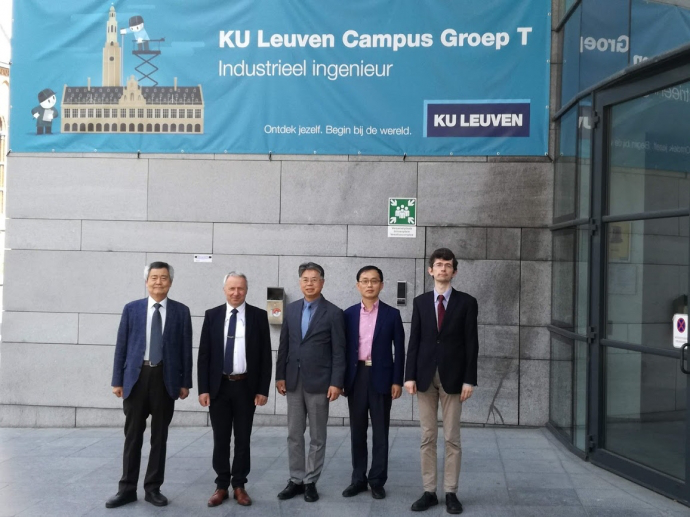

In [34]:

i_image = Image.open('5d43.jpg')
i_image

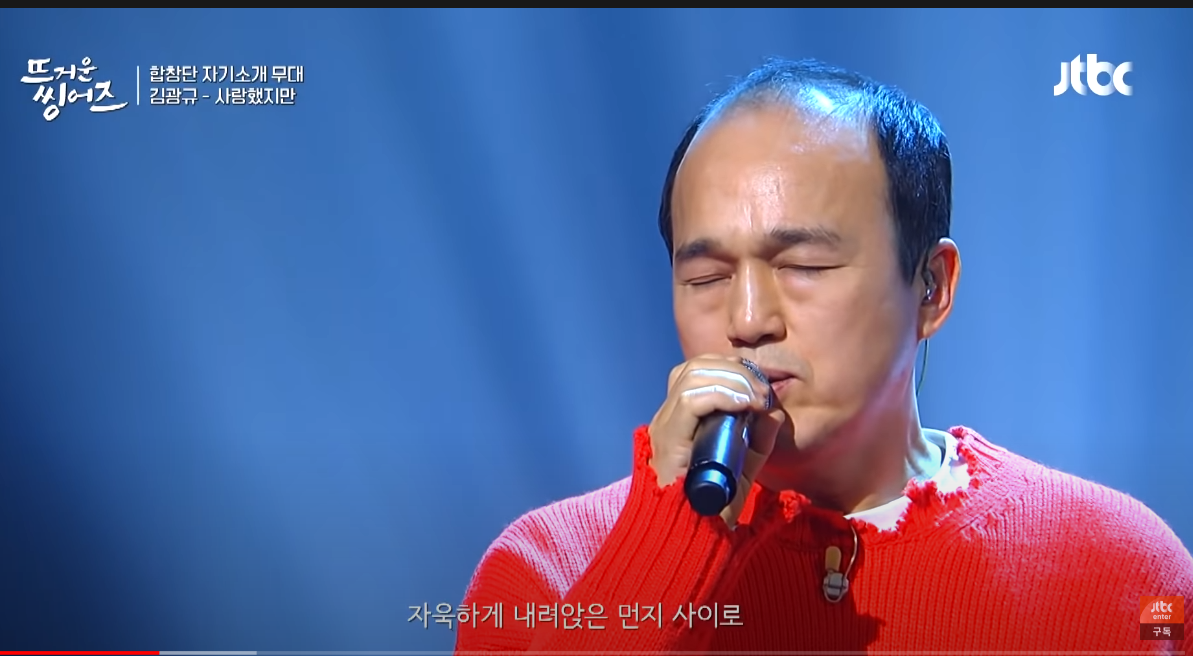

In [36]:

i_image = Image.open('rrrr.PNG')
i_image

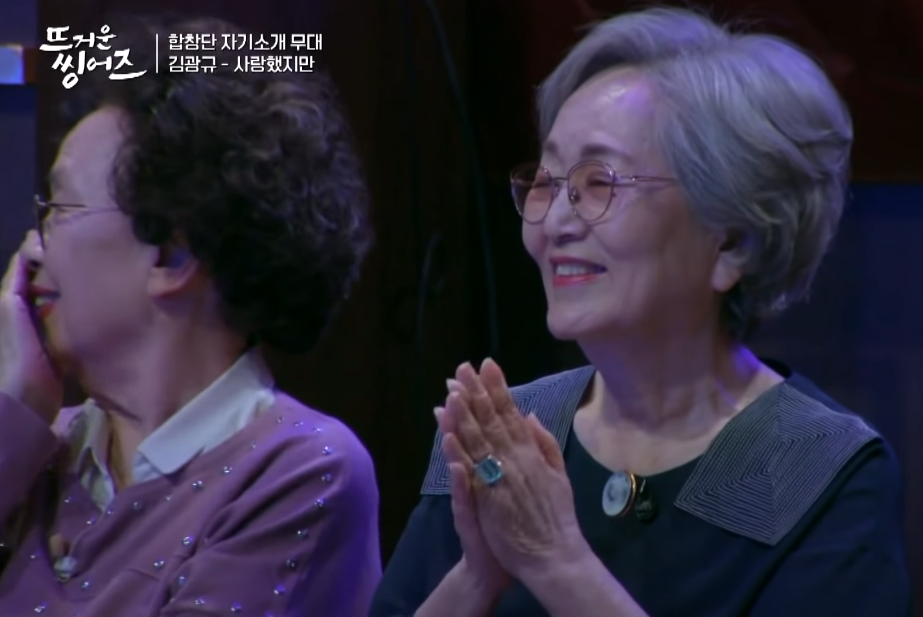

In [37]:
i_image = Image.open('RGRG.PNG')
i_image

## (Fun😁!) 또 다른 Image-To-Text 작업인 OCR(문자 인식) 예제 

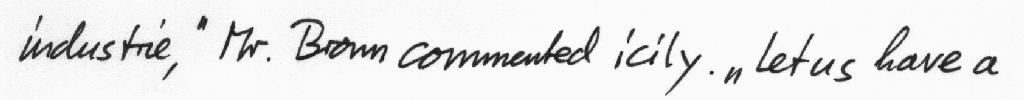

In [40]:
from IPython.display import display
from PIL import Image

img = Image.open('ocr1.png').convert("RGB")
display(img) 





NLP 계통의 오픈소스가 너무나 많이 공유되어있는 Hugging Face의 transformers 라이브러리를 통해 OCR Model을 받아옵니다.  

In [41]:
import transformers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:

def ocr_image(src_img):
  pixel_values = processor(images=src_img, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values)
  return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]




print(f"\n\n [ Model guess Your Handwriting is.. ]: \n {ocr_image(img)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [ Model guess Your Handwriting is.. ]: 
 industry, " Mr. Brown commented icily. " Let us have a


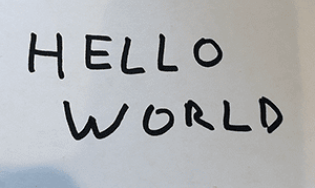

In [59]:

img2 = Image.open('hello.PNG').convert("RGB")
display(img2) 

In [60]:

print(f"\n\n [ Model guess Your Handwriting is.. ]: \n {ocr_image(img2)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [ Model guess Your Handwriting is.. ]: 
 theaters.


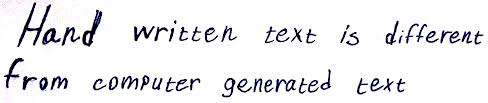

In [61]:
img3 = Image.open('HAND.jpg').convert("RGB")
display(img3) 

In [62]:

print(f"\n\n [ Model guess Your Handwriting is.. ]: \n {ocr_image(img3)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [ Model guess Your Handwriting is.. ]: 
 transachusetts generated is indifferent


?? 모델이 두줄은 인식을 못하는 듯

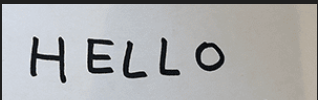

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [ Model guess Your Handwriting is.. ]: 
 hello


In [63]:
img4 = Image.open('hello1.PNG').convert("RGB")
display(img4) 


print(f"\n\n [ Model guess Your Handwriting is.. ]: \n {ocr_image(img4)}")

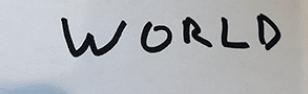

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




 [ Model guess Your Handwriting is.. ]: 
 world.


In [65]:
img5 = Image.open('hello2.PNG').convert("RGB")
display(img5) 


print(f"\n\n [ Model guess Your Handwriting is.. ]: \n {ocr_image(img5)}")